# Time Series Notebook

## Import libraries

In [38]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import RFE
from numpy.polynomial.polynomial import polyfit
from pandas import Series
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARMA

## Load data

In [39]:
!pwd

/Users/flatironschool/Documents/Mod_4_Project_Folder/mod_4_project


In [40]:
!ls

BrentOilPrices.csv        cleaner.py                practice_notebook.ipynb
Non-technical.ipynb       combine_data.csv          ts_predict_future.png
README.md                 mod_4_TS.ipynb
__pycache__               mod_4_proj_notebook.ipynb


In [41]:
brent_data = pd.read_csv('BrentOilPrices.csv')

In [42]:
# https://www.kaggle.com/mabusalah/brent-oil-prices

## Get data ready

In [43]:
print(brent_data.shape)
brent_data.head()

(8216, 2)


,Date,Price
0,"May 20, 1987",18.63
1,"May 21, 1987",18.45
2,"May 22, 1987",18.55
3,"May 25, 1987",18.60
4,"May 26, 1987",18.63


In [44]:
brent_data.Date = pd.to_datetime(brent_data.Date)

In [45]:
brent_data.set_index('Date',inplace=True)

In [46]:
print(brent_data.shape)
brent_data.head()

(8216, 1)


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [47]:
brent_data['diff1'] = brent_data.Price - brent_data.Price.shift(1)
brent_data.dropna(subset=['diff1'],inplace=True)

## Visualize data

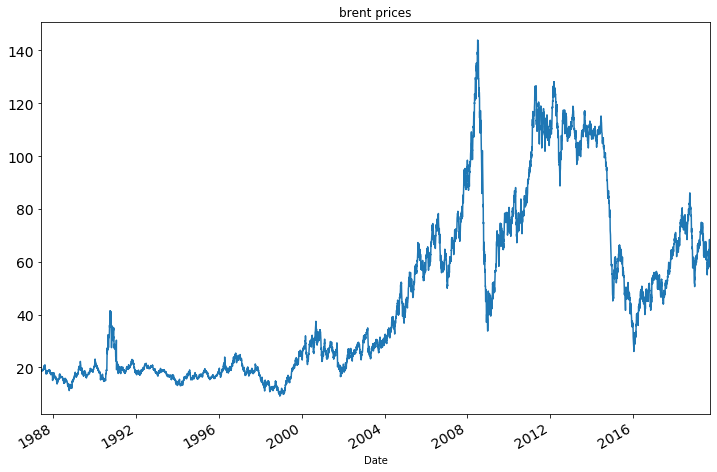

In [48]:
brent_data.Price.plot(figsize=(12,8), title= 'brent prices', fontsize=14)

,Price,diff1
Date,,
1987-05-31,18.572857,-0.007143
1987-06-30,18.860476,0.023810
1987-07-31,19.856522,0.041304
1987-08-31,18.979524,-0.066667
1987-09-30,18.313182,-0.006818


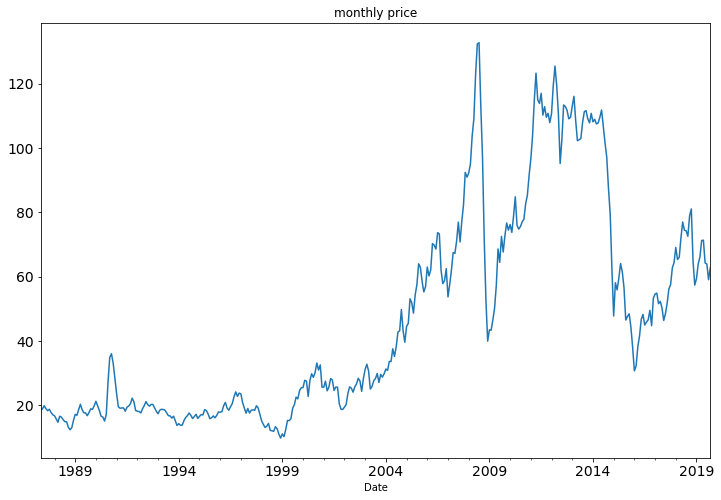

In [49]:
monthly_brent=brent_data.resample('m').mean()
monthly_brent.Price.plot(figsize=(12,8), title= 'monthly price', fontsize=14)
monthly_brent.head()

<Figure size 432x288 with 0 Axes>

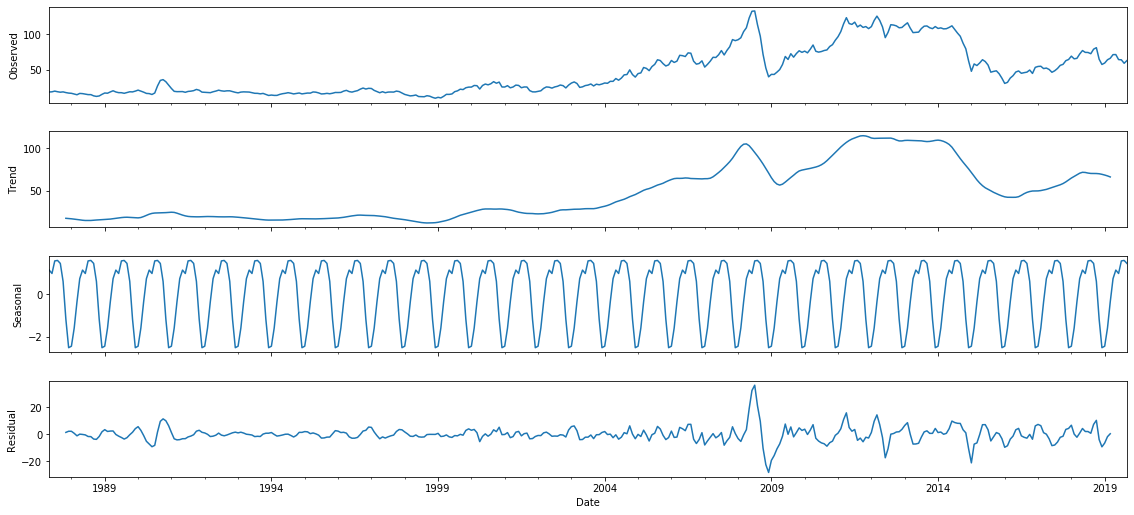

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_brent.Price, freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(18, 8)

## Remove trend

In [51]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

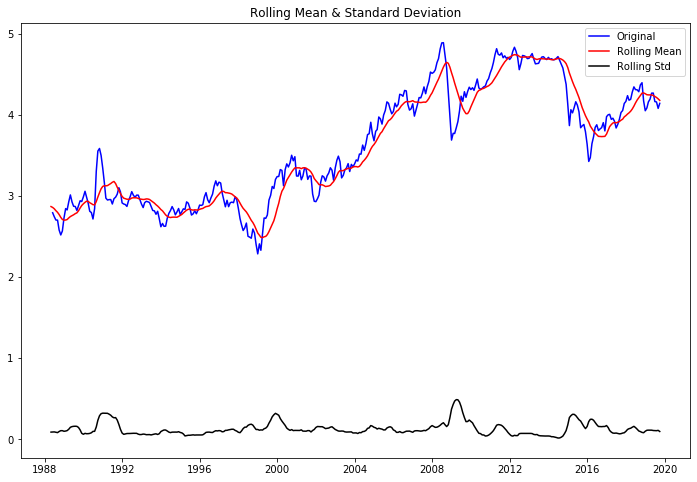

Results of Dickey-Fuller Test:
Test Statistic                  -1.640370
p-value                          0.462067
#Lags Used                       1.000000
Number of Observations Used    387.000000
Critical Value (1%)             -3.447361
Critical Value (5%)             -2.869037
Critical Value (10%)            -2.570764
dtype: float64


In [52]:
monthly_brent['log'] = monthly_brent.Price.apply(lambda x:np.log(x))
test_stationarity(monthly_brent.log, 12)

## Make data stationary

In [53]:
monthly_price_series = pd.Series(monthly_brent.Price)
monthly_log_series = pd.Series(monthly_brent.log)

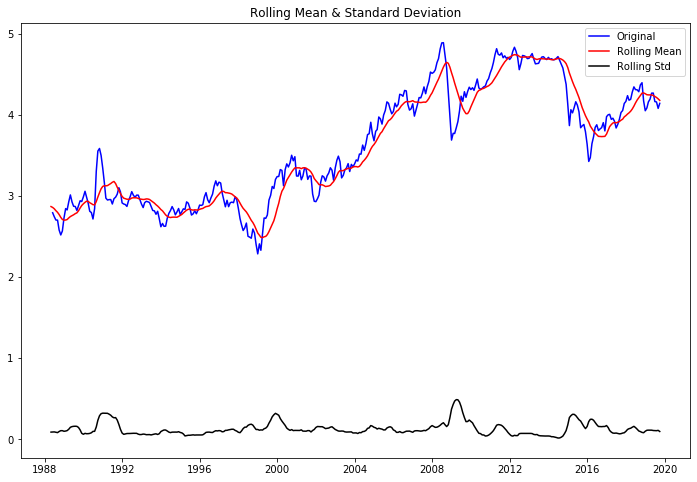

Results of Dickey-Fuller Test:
Test Statistic                  -1.640370
p-value                          0.462067
#Lags Used                       1.000000
Number of Observations Used    387.000000
Critical Value (1%)             -3.447361
Critical Value (5%)             -2.869037
Critical Value (10%)            -2.570764
dtype: float64


In [54]:
test_stationarity(monthly_log_series, 12)

In [55]:
## first order differencing
monthly_brent['diff_log'] = monthly_brent.log - monthly_brent.log.shift(1)
monthly_brent.dropna(subset=['diff_log'],inplace=True)

In [56]:
monthly_diff_series = pd.Series(monthly_brent.diff1)
monthly_diff_log_series = pd.Series(monthly_brent.diff_log)

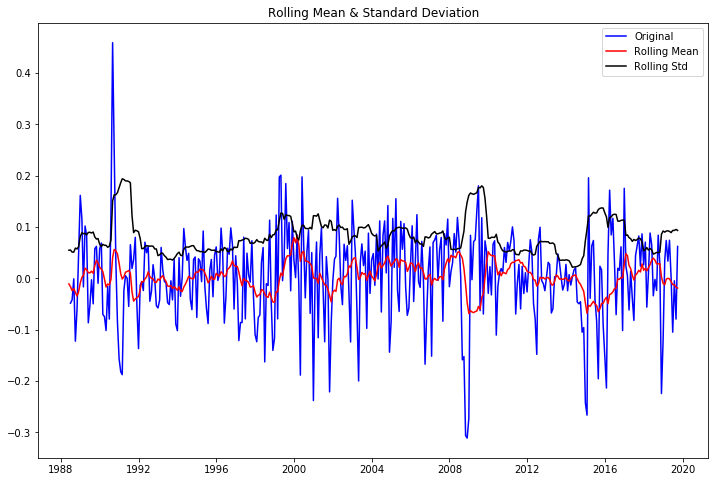

Results of Dickey-Fuller Test:
Test Statistic                -9.402466e+00
p-value                        6.135121e-16
#Lags Used                     5.000000e+00
Number of Observations Used    3.820000e+02
Critical Value (1%)           -3.447585e+00
Critical Value (5%)           -2.869136e+00
Critical Value (10%)          -2.570816e+00
dtype: float64


In [57]:
test_stationarity(monthly_diff_log_series, 12)

## ACF and PACF

In [58]:
print (monthly_brent.shape)
monthly_brent.head()

(388, 4)


,Price,diff1,log,diff_log
Date,,,,
1987-06-30,18.860476,0.023810,2.937069,0.015367
1987-07-31,19.856522,0.041304,2.988533,0.051464
1987-08-31,18.979524,-0.066667,2.943361,-0.045172
1987-09-30,18.313182,-0.006818,2.907621,-0.035740
1987-10-31,18.757727,0.014545,2.931606,0.023985


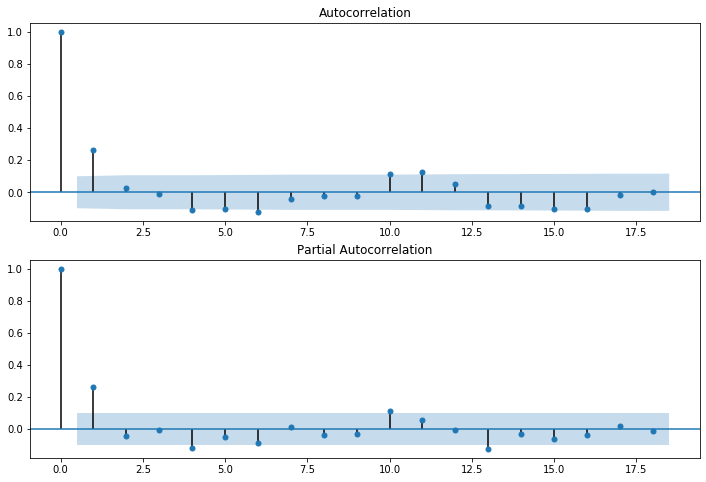

In [59]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_brent.diff_log.iloc[1:], lags=18, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_brent.diff_log.iloc[1:], lags=18, ax=ax2)

## Fitting the model

In [60]:
mod = sm.tsa.statespace.SARIMAX(monthly_brent.Price, trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  388
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1091.571
Date:                            Thu, 16 Jan 2020   AIC                           2193.143
Time:                                    12:08:54   BIC                           2212.777
Sample:                                06-30-1987   HQIC                          2200.938
                                     - 09-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3543      0.086      4.117      0.000       0.186       0.523
ma.L1         -0.0058      0.106     -0.054      0.957      -0.214       0.203
ar.S.L12       0.0811      0.044      1.857      0.063      -0.004       0.167
ma.S.L12      -0.9998      9.844     -0.102      0.919     -20.293      18.294
sigma2        17.7706    174.560      0.102      0.919    -324.360     359.901
===================================================================================
Ljung-Box (Q):                       54.78   Jarque-Bera (JB):               232.03
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):              13.10   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Check model

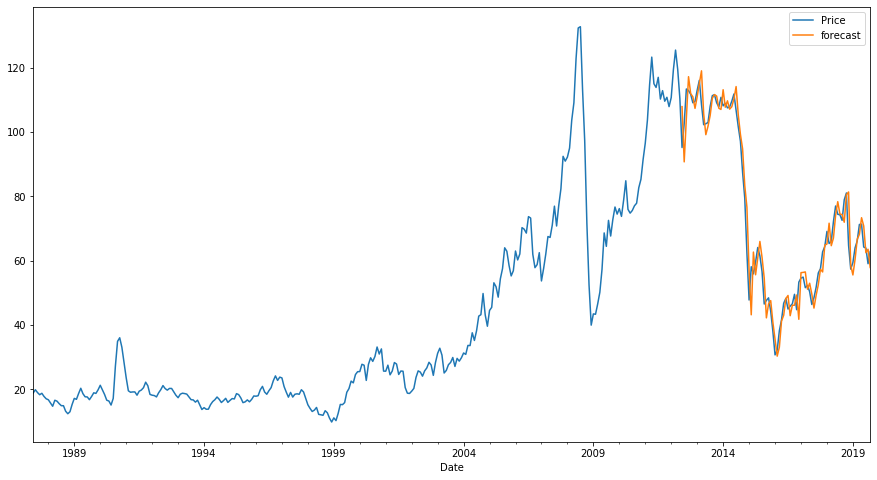

In [61]:
monthly_brent['forecast'] = res.predict(start = 300, end = 390, dynamic= False)  
monthly_brent[['Price', 'forecast']].plot(figsize=(15, 8)) 

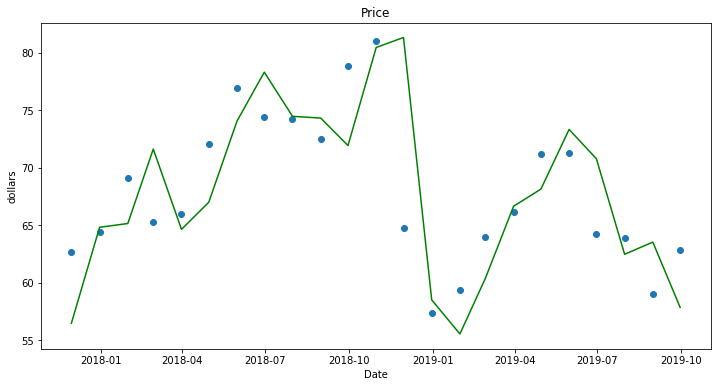

In [27]:
npredict =monthly_brent.Price['2016'].shape[0]
nobs = monthly_brent.Price.shape[0]



 
# Graph
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Price', xlabel='Date', ylabel='dollars')
ax.plot(monthly_brent.index[-npredict-npre+1:], monthly_brent.ix[-npredict-npre+1:, 'Price'], 'o', label='Observed')
ax.plot(monthly_brent.index[-npredict-npre+1:], monthly_brent.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')


## Make predictions

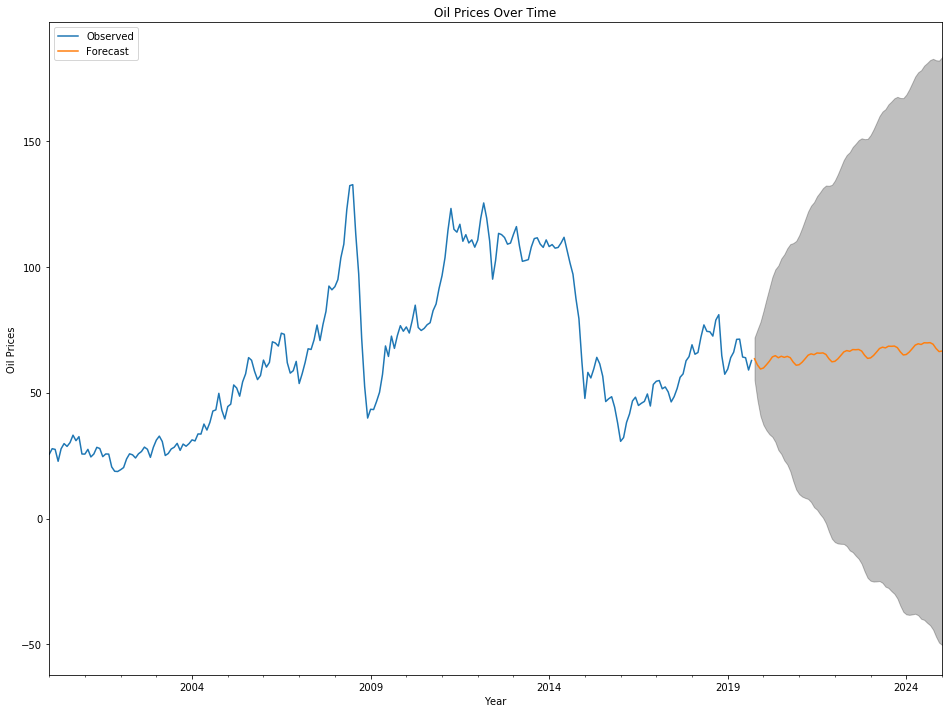

In [67]:
prediction = res.get_forecast(steps=65, dynamic = True)
pred_conf = prediction.conf_int()
ax = monthly_brent.Price.plot(label='Observed', figsize=(16,12))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Oil Prices')
plt.xlim('2000-1-1','2025-1-1')
plt.title(f'Oil Prices Over Time')
plt.legend(loc = 'upper left')
plt.show()